<a href="https://colab.research.google.com/github/mohansameer1983/NLP/blob/main/MMAI_891_Wysdom_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# This cell installs and sets up DistilBert import, as well as the dataset, which we will 
# use tf.datasets to load (https://www.tensorflow.org/datasets/catalog/overview)

!pip install -q transformers tfds-nightly

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder

try: # this is only working on the 2nd try in colab :)
  from transformers import DistilBertTokenizer, TFDistilBertModel
except Exception as err: # so we catch the error and import it again
  from transformers import DistilBertTokenizer, TFDistilBertModel

import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import regularizers

import tensorflow_datasets as tfds

import re

In [2]:
# Mount Google drive so dataset can be accessed
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

In [4]:
def load_data():
  data_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/public_data.csv")
  return data_df

orig_data = load_data()
orig_data

,id,message,label
0,10480,start the robotic vacuum,iot_cleaning
1,4210,i am sorry but i think you are not right.,general_negate
2,2443,what is the time difference between california...,datetime_convert
3,5869,tell me my list names,lists_query
4,2801,beep when i get an email from john,email_query
...,...,...,...
8879,9708,search for a train ticket to newcastle,transport_ticket
8880,8278,is there a food festival in the area,recommendation_events
8881,10509,make the lights blue in here,iot_hue_lightchange
8882,7046,play from favorites song,play_music


In [23]:
orig_data.drop_duplicates(inplace= True)

In [24]:
orig_data.isna().sum()

id         0
message    0
label      0
dtype: int64

In [25]:
max_words = []
for row in orig_data['message']:
    max_words.append(len(row.split()))
print(f"The max word count is {np.asarray(max_words).max()}")

The max word count is 25


In [26]:
def clean_data(df):

  for ind in df.index:
    
    string = df["message"][ind]
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    stop_words=['the', 'a', 'and', 'is', 'be', 'will']
    # Cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+', '', string)

    # Cleaning the html elements
    string = re.sub(r'<.*?>', '', string)

    # Removing the punctuations
    for x in string.lower(): 
        if x in punctuations: 
            string = string.replace(x, "") 

    # Converting the text to lower
    string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    df["message"][ind]=string
  return df

train_cleaned_df = clean_data(orig_data)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#Split Data

## Training Data Split

In [38]:
def extract_text_and_y(df, test_size):

  text = df['message']

  le = LabelEncoder()
  df['label_encoded'] = le.fit_transform(df['label'])
  y = df['label_encoded']

  label_dict = (train_cleaned_df[['label','label_encoded']].drop_duplicates()
              .sort_values(by='label_encoded')
              .reset_index(drop=True)['label']
              .to_dict())
  


  X_train, X_val, y_train, y_val = train_test_split(text, y, test_size=test_size, random_state=2)
  return X_train, X_val, y_train, y_val, label_dict

# the following prepares the input for running in DistilBert
train_text, val_text, train_y, val_y, label_dict = extract_text_and_y(train_cleaned_df, 0.30)

In [39]:
for index, key in label_dict.items():
    print(index, key)

0 alarm_query
1 alarm_remove
2 alarm_set
3 audio_volume_down
4 audio_volume_mute
5 audio_volume_up
6 calendar_query
7 calendar_remove
8 calendar_set
9 cooking_recipe
10 datetime_convert
11 datetime_query
12 email_addcontact
13 email_query
14 email_querycontact
15 email_sendemail
16 general_affirm
17 general_commandstop
18 general_confirm
19 general_dontcare
20 general_explain
21 general_joke
22 general_negate
23 general_praise
24 general_quirky
25 general_repeat
26 iot_cleaning
27 iot_coffee
28 iot_hue_lightchange
29 iot_hue_lightdim
30 iot_hue_lightoff
31 iot_hue_lighton
32 iot_hue_lightup
33 iot_wemo_off
34 iot_wemo_on
35 lists_createoradd
36 lists_query
37 lists_remove
38 music_likeness
39 music_query
40 music_settings
41 news_query
42 play_audiobook
43 play_game
44 play_music
45 play_podcasts
46 play_radio
47 qa_currency
48 qa_definition
49 qa_factoid
50 qa_maths
51 qa_stock
52 recommendation_events
53 recommendation_locations
54 recommendation_movies
55 social_post
56 social_query

### Visualize Data

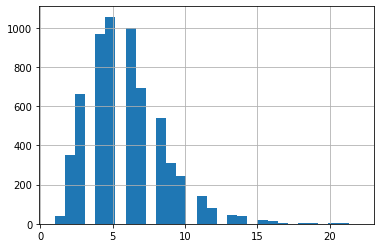

In [40]:
# Get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

## Creating Embeddings using DistilBERT 

In [47]:
#Get DistilBERT Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [51]:
# Check longest token sequence in entire text
def checkForMaxTokenSeqInData(text_list, tokenizer_i):
  
    max_val = 0
    for sent in text_list:
        try:
            sent_tok_len = len(tokenizer_i.tokenize(sent))
            max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
        except:
            pass
    
    print(f"The maximum amount of tokens in the dataset is {max_val}")
    return max_val

MAX_VAL = checkForMaxTokenSeqInData(train_text.tolist()+val_text.tolist(), 
                                    tokenizer)

The maximum amount of tokens in the dataset is 24


In [52]:
def encode_text(tokenizer_i, text, max_text_length):

    # Encode the sentence
    encodedText = tokenizer_i.batch_encode_plus(
        batch_text_or_text_pairs=text,  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = max_text_length,
        padding='max_length',
        truncation=True
        )

    # Get the input IDs and attention mask in tensor format
    input_ids = tf.convert_to_tensor(encodedText['input_ids'])
    attention_mask = tf.convert_to_tensor(encodedText['attention_mask'])

    return input_ids, attention_mask

train_input, train_mask = encode_text(tokenizer, train_text, MAX_VAL)
val_input, val_mask = encode_text(tokenizer, val_text, MAX_VAL)

train_model_inputs_and_masks = {
    'inputs' : train_input,
    'masks' : train_mask
}

val_model_inputs_and_masks = {
    'inputs' : val_input,
    'masks' : val_mask
}

# Modelling

## Build and Train Model

In [53]:
def build_model(base_model, trainable=False, params={}):
    inputs = Input(shape = (params['max_seq_length'],), dtype='int64')
    masks  = Input(shape = (params['max_seq_length'],), dtype='int64')

    base_model.trainable = trainable

    dbert_output = base_model(inputs, attention_mask=masks)
    # dbert_last_hidden_state gets you the output encoding for each of your tokens.ok 
    # Each such encoding is a vector with 768 values. The first token fed into the model is [cls]
    # which can be used to build a sentence classification network
    dbert_last_hidden_state = dbert_output.last_hidden_state

    dense_layer = Dense(params['dense_layer_1_units'],activation='relu')(dbert_last_hidden_state[:, 0, :])
    dropout_layer = Dropout(params['dropout_rate_1'])(dense_layer)
    dense_layer = Dense(params['dense_layer_2_units'],activation='relu')(dropout_layer)
    probs = Dense(len(label_dict), activation='softmax',kernel_regularizer=regularizers.l2(params['regularizer_l2_rate']), name="output")(dense_layer)

    model = keras.Model(inputs=[inputs, masks], outputs=probs)
    model.summary()
    return model

dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
params={
        "dense_layer_1_units": 128,        
        "dropout_rate_1": 0.1,
	      "dense_layer_2_units": 64,
        "regularizer_l2_rate":0.01,
        "max_seq_length":MAX_VAL
        }

model = build_model(dbert_model, params=params)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 24)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 24)]         0           []                               
                                                                                                  
 tf_distil_bert_model_2 (TFDist  TFBaseModelOutput(l  66362880   ['input_5[0][0]',                
 ilBertModel)                   ast_hidden_state=(N               'input_6[0][0]']                
                                one, 24, 768),                                                    
                                 hidden_states=None                                         

In [55]:
def compile_model(model):

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    loss = keras.losses.sparse_categorical_crossentropy
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics='accuracy')
    return model

model = compile_model(model)

In [ ]:
def train_model(model, model_inputs_and_masks_train, model_inputs_and_masks_val,
    y_train, y_val, batch_size, num_epochs):

    # Training Data - Tensor Conversion
    input_ids_train = model_inputs_and_masks_train['inputs']
    attention_masks_train = model_inputs_and_masks_train['masks']
    labels_train = tf.convert_to_tensor(y_train[:])

    # Validation data - Tensor Conversion
    input_ids_val = model_inputs_and_masks_val['inputs']
    attention_masks_val = model_inputs_and_masks_val['masks']
    labels_val = tf.convert_to_tensor(y_val[:])

    # Preparing Training Dataset
    dataset_train = tf.data.Dataset.from_tensors(( (input_ids_train, attention_masks_train), labels_train ))

    history = model.fit(dataset_train,
          epochs=num_epochs,
          validation_data=([input_ids_val,attention_masks_val],labels_val),
          batch_size=batch_size, verbose=1)
    
    return model, history

model, history = train_model(model, train_model_inputs_and_masks, val_model_inputs_and_masks, train_y, val_y, batch_size=128, num_epochs=5)

Epoch 1/5
1/1 [==============================] - 378s 378s/step - loss: 4.8636 - accuracy: 0.0111 - val_loss: 4.8586 - val_accuracy: 0.0068
Epoch 2/5
1/1 [==============================] - 367s 367s/step - loss: 4.8603 - accuracy: 0.0117 - val_loss: 4.8578 - val_accuracy: 0.0068
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8612 - accuracy: 0.0145